<h1 style="background-color: #ffd5cd; text-align: center"> Extracting Financial 10-K Statements from SEC'S EDGAR Database</h1>

In this notebook, I aim to extract financial 10-K statements from the U.S. *Securities and Exchange Commision (SEC's)*, EDGAR database. In order to give an example, I would be extracting financial 10-K statements of 5 companies that belong to different sectors. These 5 stocks will constitute my diverse portfolio. This notebook is a work-in-progress. I would be leveraging the textual information from financial 10-K statements to perform NLP Analysis on them. This notebook covers extracting financial 10-K statements of companies and their preprocessing steps. The notebook is organized as follows:

1. SEC EDGAR database overview.
2. Fetching financial 10-K reports via SEC API
3. Download 10-K statements
4. Get documents.
5. Get document types.
6. Preprocessing 10-K documents
    * Parsing via BeautifulSoup
    * Lemmatization
    * Stop-words removal
7. Future work
8. References

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gov-names/Gov Orgs ONS.xlsx


<h1 style="background-color: #ffd5cd; text-align: center"> SEC EDGAR Database Overview</h1>

The SEC has created a website called Electronic Data Gathering Analysis Retrieval (EDGAR) that gives us straightforward access to all the available financial statements and is leveraged by the proposed framework to extract 10-K reports of the selected stocks. Table 1 shows the list of companies whose 10-K statements I would be extracting.


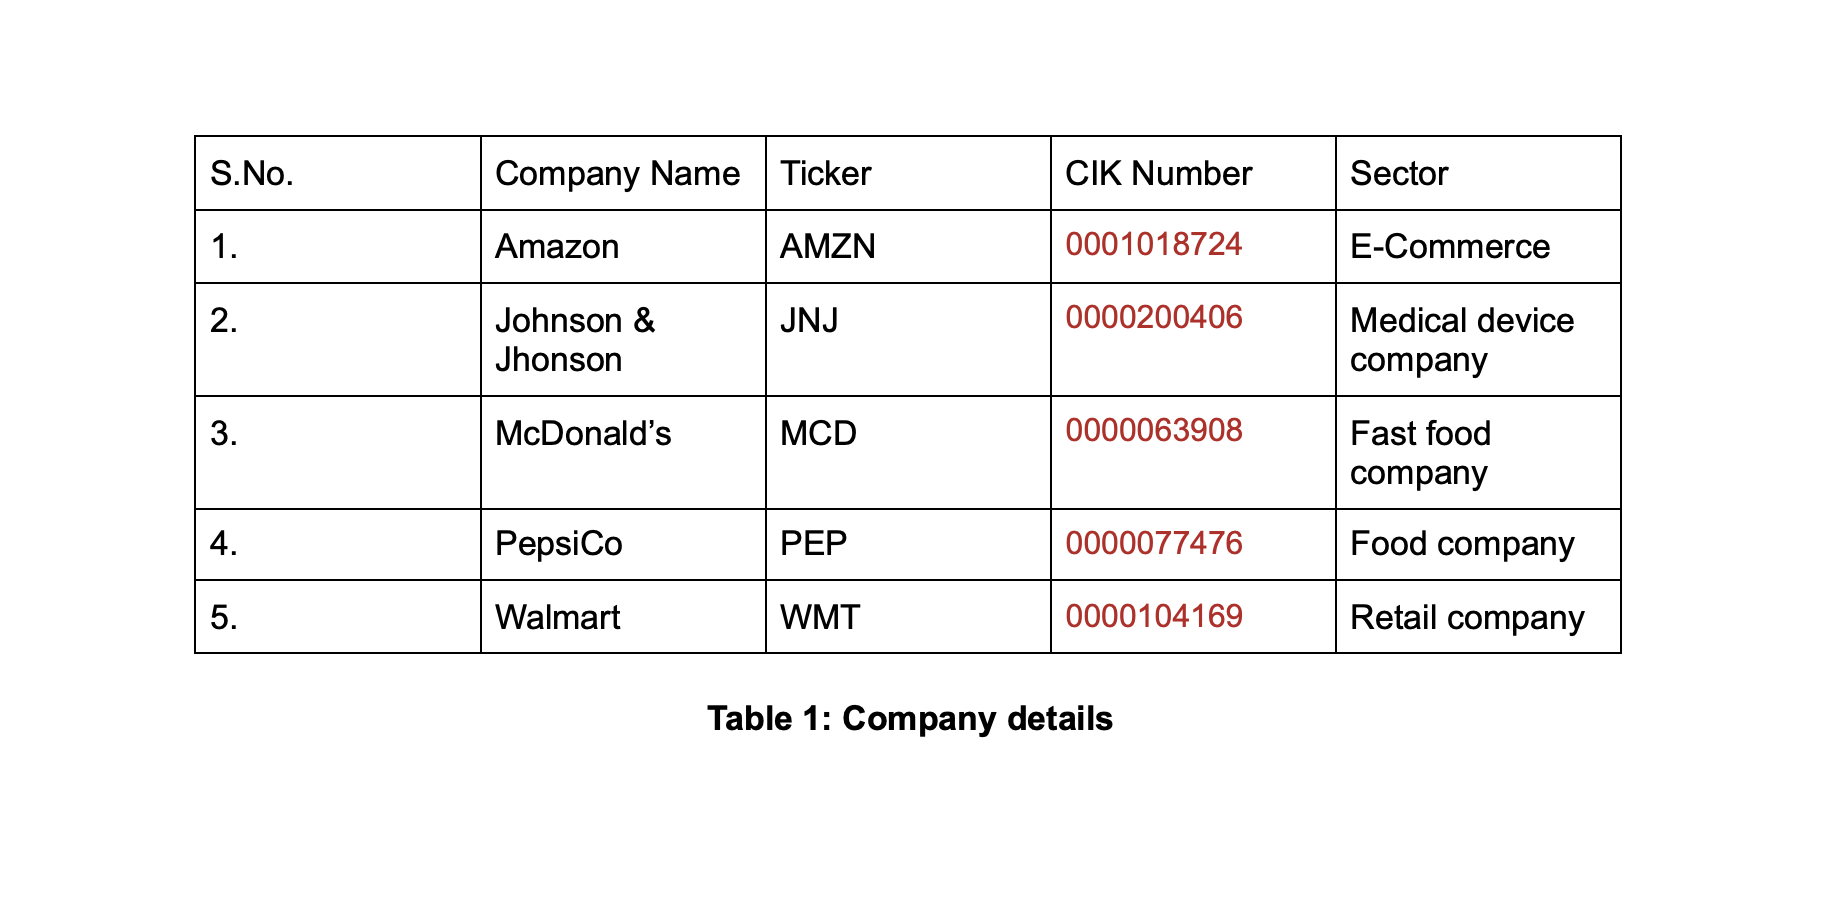




Below, I have explained the steps to follow in order to leverge SEC API to extract the 10-K filings. 

<h1 style="background-color: #ffd5cd; text-align: center"> Fetching Financial 10-K Reports via SEC API</h1>

When companies file their 10-K reports to the SEC, it is gathered in the EDGAR database and is publicly available for investors to download or search for company-wise filing reports, we need to submit an HTTPS request to the following REST Url:

<p style="text-align:center; color:blue;">https://www.sec.gov/cgi-bin/browse-edgar</p>

To specify  the details of the report in which we are specifically interested in, we need to pass the following query parameters. To specify the details of the report in which we are specifically interested in, we need to pass the following query parameters:

1. *CIK number (CIK)*: a unique numerical identifier assigned by the EDGAR system.
2. *Report type (type)*:  type of financial report that we wish to query. Example 10-K, 10-Q, 14-K.
3. *Prior-to date (dateb)*: EDGAR accepts a prior-to date that identifies the latest date in which we are interested.   
4. *The number of reports (count)*: this quantity describes the number of filings up to the prior-to date.
5. *Ownership (owner)*: The SEC requires filings from individuals who own significant amounts of the company’s stock. Setting the owner parameter to exclude, EDGAR won’t provide reports related to its director or officer ownership [1].

As an example, to download Nike’s annual report before 2020, where Nike’s CIK number is 0000320187, and 10-K denotes the type of annual reports, we would form the EDGAR Url as follows :

<p style="text-align:center; color:blue"> https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000320187&type=10-K&dateb=20200101&count=60&owner=exclude</p>

 
 

In [2]:
cik_lookup = {
    'AMZN': '0001018724',
    'JNJ': '0000200406',   
    'MCD': '0000063908',
    'PEP': '0000077476',
    'WMT': '0000104169'}

In [3]:
!pip install ratelimit

  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5892 sha256=421480ea5ac9a2f14a7b457bcad7cb9de54e29b2694bdecbfebaa96492116bd9
  Stored in directory: /root/.cache/pip/wheels/5d/c2/23/4915cca200175fece0d5015f1981f4e1ecb5e3ef40b66cf525
Successfully built ratelimit
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
from ratelimit import limits, sleep_and_retry
import requests

class SecAPI(object):
    SEC_CALL_LIMIT = {'calls': 10, 'seconds': 1}

    @staticmethod
    @sleep_and_retry
    @limits(calls=SEC_CALL_LIMIT['calls'] / 2, period=SEC_CALL_LIMIT['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text

def print_ten_k_data(ten_k_data, fields, field_length_limit=50):
    indentation = '  '

    print('[')
    for ten_k in ten_k_data:
        print_statement = '{}{{'.format(indentation)
        for field in fields:
            value = str(ten_k[field])

            if isinstance(value, str):
                value_str = '\'{}\''.format(value.replace('\n', '\\n'))
            else:
                value_str = str(value)

            if len(value_str) > field_length_limit:
                value_str = value_str[:field_length_limit] + '...'

            print_statement += '\n{}{}: {}'.format(indentation * 2, field, value_str)

        print_statement += '},'
        print(print_statement)
    print(']')


In [5]:
from bs4 import BeautifulSoup

sec_api = SecAPI()

def get_sec_data(cik, doc_type, start=0, count=60):
    newest_pricing_date = pd.to_datetime('2018-08-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    return sec_data

Hitting the EDGAR REST Url that we formed above would redirect us to a web page that contains tabular data related to the company’s type of filing document, document description, filing date, and file number. Figure 1 shows the EDGAR’s search result dashboard after hitting the REST Url formed above.

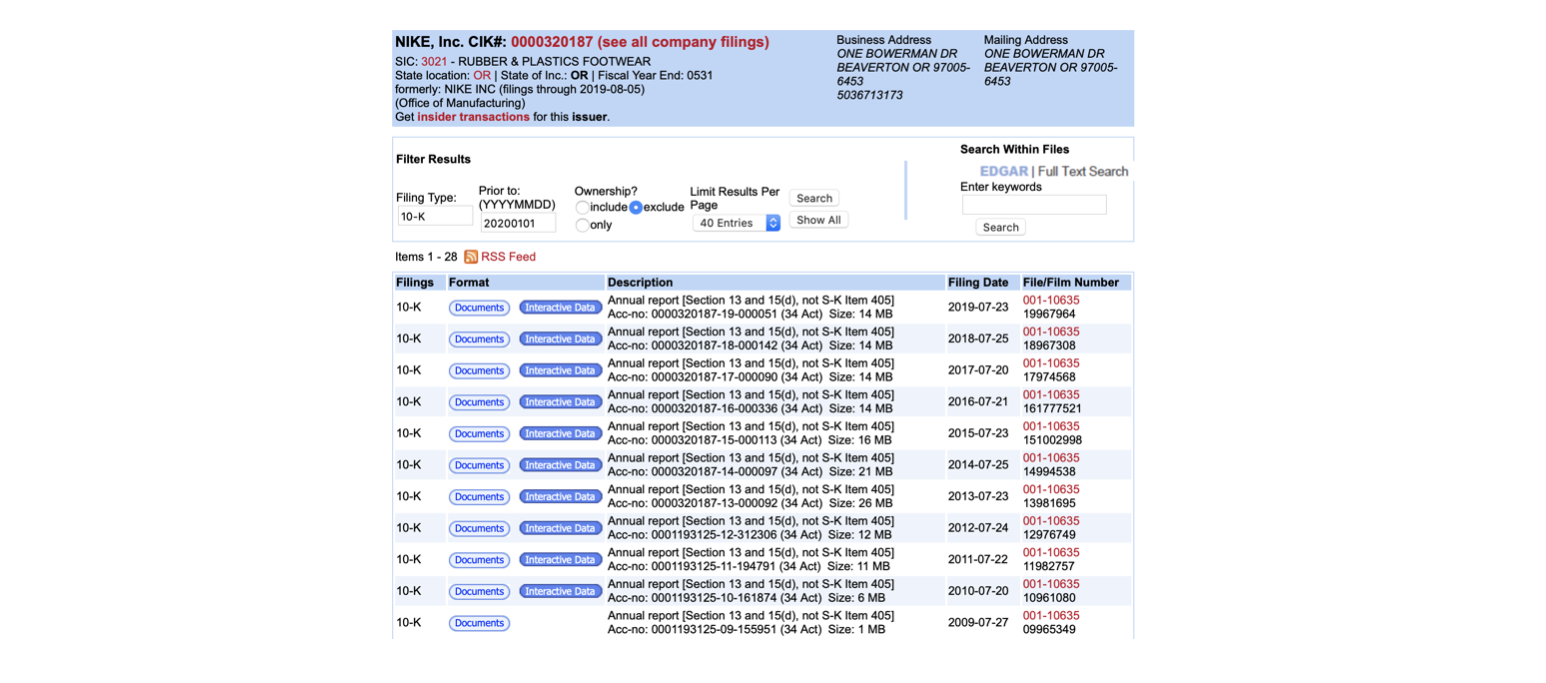<br>
<p style="text-align:center;"><b>Figure 1: EDGAR search results for Nike’s 10-K documents prior-to 2020-01-01.</b>
</p>


After fetching the web page as a response, we can perform web scraping with Python by leveraging the *BeautifulSoup* library and access the links that would help us download the 10-K filing reports. These document links will help us download the pure HTML version of the desired 10-K document, which we store in a dictionary against the corresponding stock’s CIK number.

In [6]:
def get_sec_data(cik, doc_type, start=0, count=60):
    newest_pricing_data = pd.to_datetime('2020-01-01')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

Let's pull the list using the `get_sec_data` function, then display some of the results. For displaying some of the data, we'll use Amazon as an example.

In [7]:
import pprint

example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/0001018724-19-000004-index.htm',
  '10-K',
  '2019-02-01'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872418000005/0001018724-18-000005-index.htm',
  '10-K',
  '2018-02-02'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872416000172/0001018724-16-000172-index.htm',
  '10-K',
  '2016-01-29'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872415000006/0001018724-15-000006-index.htm',
  '10-K',
  '2015-01-30')]


<h1 style="background-color: #ffd5cd; text-align: center"> Download 10-K Statements</h1>

In [8]:
from tqdm import tqdm

raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-19-000004.txt : 20190201
<SEC-HEADER>0001018724-19-000004.hdr.sgml : 20190201
<ACCEPTANCE-DATETIME>20190131202240
ACCESSION NUMBER:		0001018724-19-000004
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		106
CONFORMED PERIOD OF REPORT:	20181231
FILED AS OF DATE:		20190201
DATE AS OF CHANGE:		20190131

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		19557427

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<

<h1 style="background-color: #ffd5cd; text-align: center"> Get Documents</h1>

With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag in between.

In [9]:
import re


def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """

    final_docs = []
    start_regex = re.compile(r'<DOCUMENT>')
    end_regex = re.compile(r'</DOCUMENT>')
    
    start_idx = [x.end() for x in re.finditer(start_regex, text)]
    end_idx = [x.start() for x in re.finditer(end_regex, text)]
    
    for start_i, end_i in zip(start_idx, end_idx):
        final_docs.append(text[start_i:end_i])
    
    
    return final_docs

In [10]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from WMT Fillings: 100%|██████████| 25/25 [00:00<00:00, 62.22filling/s]

Document 0 Filed on 2019-02-01:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20181231x10k.htm
<DESCRIPTION>10-K
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<head>
	...

Document 1 Filed on 2019-02-01:

<TYPE>EX-10.7
<SEQUENCE>2
<FILENAME>amzn-20181231xex107.htm
<DESCRIPTION>EXHIBIT 10.7
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht...

Document 2 Filed on 2019-02-01:

<TYPE>EX-21.1
<SEQUENCE>3
<FILENAME>amzn-20181231xex211.htm
<DESCRIPTION>EXHIBIT 21.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht...


<h1 style="background-color: #ffd5cd; text-align: center">Get Document Types</h1>

Now that we have all the documents, we want to find the 10-k form in this 10-k filing. The `get_document_type` function returns the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`.

In [11]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    # Regex explaination : Here I am tryng to do a positive lookbehind
    # (?<=a)b (positive lookbehind) matches the b (and only the b) in cab, but does not match bed or debt.
    # More reference : https://www.regular-expressions.info/lookaround.html
    
    type_regex = re.compile(r'(?<=<TYPE>)\w+[^\n]+') # gives out \w
    type_idx = re.search(type_regex, doc).group(0).lower()
    return type_idx

In [12]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})

print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2018123...
    file_date: '2019-02-01'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2017123...
    file_date: '2018-02-02'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '2017-02-10'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2015123...
    file_date: '2016-01-29'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2014123...
    file_date: '2015-01-30'},
]


<h1 style="background-color: #ffd5cd; text-align: center">Preprocessing 10-K documents</h1>

<h2 style="background-color: #ffd5cd; text-align: center">Parsing via BeautifulSoup</h2>

In [13]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

In [14]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning WMT 10-Ks: 100%|██████████| 25/25 [00:18<00:00,  1.3710-K/s]

[
  {
    file_clean: '\n10-k\n1\namzn-20181231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20171231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20161231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20151231x10k.htm\nform 10-k\n\n\n...},
  {
    file_clean: '\n10-k\n1\namzn-20141231x10k.htm\nform 10-k\n\n\n...},
]


<h2 style="background-color: #ffd5cd; text-align: center">Lemmatization</h2>

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """

    wnl = WordNetLemmatizer()
    lemmatized_words = [wnl.lemmatize(word, 'v') for word in words]
    
    return lemmatized_words

In [16]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))

Lemmatize WMT 10-Ks: 100%|██████████| 25/25 [00:03<00:00,  7.3710-K/s]


In [17]:
print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20181231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20171231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20141231x10k', 'htm', '...},
]


<h2 style="background-color: #ffd5cd; text-align: center">Stop-words Removal</h2>

In [18]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]
        
        
print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Remove Stop Words for WMT 10-Ks: 100%|██████████| 25/25 [00:01<00:00, 21.6410-K/s]

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20181231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20171231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20151231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20141231x10k', 'htm', '...},
]


<h1 style="background-color: #ffd5cd; text-align: center">Future Work</h1>

This notebook is a *work-in-progress*. In future, I intend to work on the following -
1. Perform sentiment analysis on financial documents.
2. Create a separate financial dataset out of the preprocessed 10-K documents.
3. Leverage Loughran-McDonald financial sentiment word-list with this dataset.

<h1 style="background-color: #ffd5cd; text-align: center">References</h1>

1. [GitHub - AI for Trading](https://github.com/purvasingh96/AI-for-Trading/tree/master/Term%202/Projects/Project%20-%205%20-%20NLP%20on%20Financial%20Statements)
2. [SEC website](https://www.sec.gov/edgar/searchedgar/companysearch.html)
3. [Udacity's Nanodegree materials](https://www.udacity.com/course/ai-for-trading--nd880)